In [47]:
# from google.colab import drive
# drive.mount('/content/drive')

# Assignment 1

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: POS tagging, Sequence labelling, RNNs


# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

# Introduction

You are tasked to address the task of POS tagging.

<center>
    <img src="images/pos_tagging.png" alt="POS tagging" />
</center>

# [Task 1 - 0.5 points] Corpus

You are going to work with the [Penn TreeBank corpus](https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip).

**Ignore** the numeric value in the third column, use **only** the words/symbols and their POS label.

### Example

```Pierre	NNP	2
Vinken	NNP	8
,	,	2
61	CD	5
years	NNS	6
old	JJ	2
,	,	2
will	MD	0
join	VB	8
the	DT	11
board	NN	9
as	IN	9
a	DT	15
nonexecutive	JJ	15
director	NN	12
Nov.	NNP	9
29	CD	16
.	.	8
```

### Splits

The corpus contains 200 documents.

   * **Train**: Documents 1-100
   * **Validation**: Documents 101-150
   * **Test**: Documents 151-199

### Instructions

* **Download** the corpus.
* **Encode** the corpus into a pandas.DataFrame object.
* **Split** it in training, validation, and test sets.

#### Preliminaries

#### Out of Vocabulary (OOV) words in training set
We see words in the training set that are not alredy embedded through Glove (50) model, in addition we define the set oov_terms with all those words.

In [48]:
# seeds = [1, 40, 375]
# from numpy.random import seed
# seed(seeds[0])
# from tensorflow import set_random_seed
# set_random_seed(seeds[0])

In [49]:
# file management
import os
import urllib
import zipfile
from pathlib import Path

# dataframe management
import pandas as pd

# data manipulation
import numpy as np

# for readability
from typing import Iterable
from tqdm import tqdm

In [50]:
# ! pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [51]:
import random 

def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    random.seed(seed)
    np.random.seed(seed)
    
    # Set the seed using keras.utils.set_random_seed. This will set:
    # 1) `numpy` seed
    # 2) backend random seed
    # 3) `python` random seed
    keras.utils.set_random_seed(seed)
    tf.random.set_seed(seed)

    # If using TensorFlow, this will make GPU ops as deterministic as possible,
    # but it will affect the overall performance, so be mindful of that.
    tf.config.experimental.enable_op_determinism()

# fix_random(seed=0)

In [52]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(download_path: Path, url: str):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=download_path, reporthook=t.update_to)

def download_dataset(download_path: Path, url: str):
    print("Downloading dataset...")
    download_url(url=url, download_path=download_path)
    print("Download complete!")

def extract_dataset(download_path: Path, extract_path: Path):
    print("Extracting dataset... (it may take a while...)")

    with zipfile.ZipFile(download_path) as loaded_tar:
        loaded_tar.extractall(path=extract_path, pwd=None)
    print("Extraction completed!")

In [53]:
url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
dataset_name = "dependency_treebank"

print(f"Current work directory: {Path.cwd()}")
dataset_folder = Path.cwd().joinpath("Datasets")

if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)

dataset_tar_path = dataset_folder.joinpath("dependency_treebank.zip")
dataset_path = dataset_folder.joinpath(dataset_name)

if not dataset_tar_path.exists():
    download_dataset(dataset_tar_path, url)

if not dataset_path.exists():
    extract_dataset(dataset_tar_path, dataset_folder)

Current work directory: c:\Users\Utente\Desktop\UNIVERSITA'\AI\2 Anno\Natural Language Processing\_ Esame\Assignment 1\NLP_POS-tagging


#### Encode and Split

The aim of the code below is to find a way to create a dataframe starting from all the files downloaded before.
For every downloaded file, we check the number through the function find_number(), we decide if it belongs to train, validation or test given that number, we then split it into rows to get the word and the POS and to check where a phrase ends. Given all this informations we can create a list whose columns are:
1. num_file: the number of the file
2. phrase_id: the id of the phrase contained in a file
3. text: the text that has to be analyzed
4. pos: the tag assigned to the text
5. split: the split to which the text belongs

In [54]:
import re

def find_number(string):
    """
    This function finds the number written in a string.
    """
    return re.findall(r'\d+', string)

In [55]:
dataframe_rows = []
id = 0

folder = dataset_folder.joinpath(dataset_name)
for file_path in folder.glob('*.dp'):
    num_file = int(find_number(file_path.name)[0])
    id = 1

    with file_path.open(mode='r', encoding='utf-8') as text_file:

        if num_file < 101:
            split = "train"
        elif num_file >= 101 and num_file < 151:
            split = "validation"
        else:
            split = "test"

        for row in text_file.readlines():
            if row=='\n' or row=='':
                id += 1

            else:
                text, pos, _ = row.split('\t')

                dataframe_row = {
                    "num_file": num_file,
                    "phrase_id": str(num_file) + "_" + str(id),
                    "text": text,
                    "pos": pos,
                    "split": split
                }

                dataframe_rows.append(dataframe_row)

In [56]:
df = pd.DataFrame(dataframe_rows)
df.head(20)

,num_file,phrase_id,text,pos,split
0,1,1_1,Pierre,NNP,train
1,1,1_1,Vinken,NNP,train
2,1,1_1,",",",",train
3,1,1_1,61,CD,train
4,1,1_1,years,NNS,train
5,1,1_1,old,JJ,train
6,1,1_1,",",",",train
7,1,1_1,will,MD,train
8,1,1_1,join,VB,train
9,1,1_1,the,DT,train


# [Task 2 - 0.5 points] Text encoding

To train a neural POS tagger, you first need to encode text into numerical format.

### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.
* [Optional] You are free to experiment with text pre-processing: **make sure you do not delete any token!**

In [57]:
# typing
from typing import List, Callable, Dict

#### Text pre-processing
In the code below we pre-processed the df dataframe in order to reduce the number of different words. Our text pre-processing consist just in lowering the text of words. <br>
**NB: should we add somenthing to the pre processing?**

In [58]:
import re
from functools import reduce
import nltk
from nltk.corpus import stopwords

In [59]:
def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    """
    return text.lower()

In [60]:
PREPROCESSING_PIPELINE = [
                          lower
                          ]

def text_prepare(text: str,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """
    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE
    return reduce(lambda txt, f: f(txt), filter_methods, text)

In [61]:
print('Pre-processing text...')

print()
print(f'[Debug] Before:\n{df.text.values[0]}')
print()

# Replace each sentence with its pre-processed version
df['text'] = df['text'].apply(lambda txt: text_prepare(txt))

print(f'[Debug] After:\n{df.text.values[0]}')
print()

print("Pre-processing completed!")

Pre-processing text...

[Debug] Before:
Pierre

[Debug] After:
pierre

Pre-processing completed!


#### Vocabulary creation for training set
We define a vocabulary for the training set assigning to each word a random index, the building_vocabulary function returns a list containing:<br>
- word vocabulary: vocabulary index to word
- inverse word vocabulary: word to vocabulary index
- word listing: set of unique terms that build up the vocabulary


In [62]:
df_train = df[df['split']=='train']
df_val = df[df['split']=='validation']
df_test = df[df['split']=='test']

#### GloVe embeddings (50)
Download GloVe 50 embedding where most of the words are alredy embedded in an embedding model that associate each word to a vector of dimension 50.

In [63]:
# !pip install gensim

In [64]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""

    if model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    else:
        raise AttributeError("Unsupported embedding model type! Available one: glove")

    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

In [65]:
embedding_dim = 50

embedding_model = load_embedding_model(model_type="glove",
                                       embedding_dimension=embedding_dim)

In [66]:
vocab = {} # word to idx
embedding_matrix_glove = np.zeros((400001, embedding_dim))

for i in range(0, 400000):
    vocab[embedding_model.index_to_key[i]] = i+1
    embedding_matrix_glove[i+1] = embedding_model.vectors[i]

print(f'Embedding matrix shape: {embedding_matrix_glove.shape}')

Embedding matrix shape: (400001, 50)


In [67]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [68]:
word_listing = set(df_train['text'])
oov_terms = check_OOV_terms(embedding_model, word_listing)
oov_percentage = float(len(oov_terms)) * 100 / len(word_listing)
print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")

Total OOV terms: 359 (4.85%)


Here we add the OOV in the train set to the vocabulary and the embedded matrix </br>
*NB: maybe is better to define the OOV as the mean of all the other word, link for report (https://stackoverflow.com/questions/49239941/what-is-unk-in-the-pretrained-glove-vector-files-e-g-glove-6b-50d-txt)* <br>
Our embedding matrix has the following columns:
- column 0 is all zeros, represents the embedding vector for padding
- columns 1 to 400001 are the embedding vectors for the words in GloVe
- columns 400002 to 400360 are the embedding vectors for the words OOV in the training set (random vector)
- column 400361 is the embedding vector for the words UNK in the final vocabulary

In [69]:
for word in oov_terms:
    vocab[word] = 400002 + oov_terms.index(word)
    embedding_matrix_glove = np.append(embedding_matrix_glove, np.random.uniform(-0.25, 0.25, 50).reshape(1, 50), axis=0)

vocab['[UNK]'] = len(vocab) + 1
average_oov = np.mean(embedding_matrix_glove, axis=0)
embedding_matrix = np.append(embedding_matrix_glove, average_oov.reshape(1, 50), axis=0)

vocab['[PAD]'] = 0

print(len(vocab))
print(f"New embedding matrix size: {embedding_matrix.shape}")

400361
New embedding matrix size: (400361, 50)


#### Embedding for training set
We create the embedding matrix for all the training set:
- using GloVe embeddings for alredy known words
- assigning to each OOV word a random value.

**NB: maybe instead of random we can define OOV with the mean of its neighbour word embeddings (tutorial 2)** <br>
**NB: we can even add all embedding in GloVe to the embedding matrix, even if they are not in train set**

# [Task 3 - 1.0 points] Model definition

You are now tasked to define your neural POS tagger.

### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.
* **Model 2**: add an additional Dense layer to the Baseline model.

* **Do not mix Model 1 and Model 2**. Each model has its own instructions.

**Note**: if a document contains many tokens, you are **free** to split them into chunks or sentences to define your mini-batches.

In [70]:
# utils functions for padding and encoding

list_of_pos = list(set(df_train['pos']))

def pos_to_int(string):
    if string == '[PAD]':
        return np.zeros((45,), dtype=int).tolist()
    length = len(list_of_pos)
    for i in range(length):
        if list_of_pos[i] == string:
            return [1 if j == i else 0 for j in range(length)]

def int_to_pos(phrase_hot_encodings):
    return [list_of_pos[np.argmax(word)] for word in phrase_hot_encodings]

#### Baseline
**NB: reference slides 08 pag 38** <br>
https://analyticsindiamag.com/complete-guide-to-bidirectional-lstm-with-python-codes/

In [71]:
batch_size = 64
GloVe_dim = 50 # GloVe embedding
units_bi = 64
units_bi_2 = 32

n_unique_words = len(vocab) # input dimension
outputs_dim = len(list_of_pos)

In [72]:
baseline = tf.keras.Sequential(name='Baseline')

# baseline.add(layers.Embedding(n_unique_words, GloVe_dim, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), mask_zero=True, trainable=False))
baseline.add(layers.Embedding(n_unique_words, GloVe_dim, weights=[embedding_matrix], mask_zero=True, trainable=False))
baseline.add(layers.Masking(mask_value=0))
baseline.add(layers.Bidirectional(layers.LSTM(units_bi, activation='relu', return_sequences=True)))
baseline.add(layers.TimeDistributed(layers.Dense(outputs_dim, activation='softmax')))

baseline.summary()

Model: "Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 50)          20018050  
                                                                 
 masking_3 (Masking)         (None, None, 50)          0         
                                                                 
 bidirectional_4 (Bidirecti  (None, None, 128)         58880     
 onal)                                                           
                                                                 
 time_distributed_3 (TimeDi  (None, None, 45)          5805      
 stributed)                                                      
                                                                 
Total params: 20082735 (76.61 MB)
Trainable params: 64685 (252.68 KB)
Non-trainable params: 20018050 (76.36 MB)
_________________________________________________________________


#### Model 1

In [83]:
model_1 = tf.keras.Sequential(name='Model_1')

# model_1.add(layers.Embedding(n_unique_words, GloVe_dim, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), mask_zero=True, trainable=False))
model_1.add(layers.Embedding(n_unique_words, GloVe_dim, weights=[embedding_matrix], mask_zero=True, trainable=False))
model_1.add(layers.Masking(mask_value=0))
model_1.add(layers.Bidirectional(layers.LSTM(units_bi, activation='relu', return_sequences=True)))
model_1.add(layers.Bidirectional(layers.LSTM(units_bi, activation='relu', return_sequences=True)))
model_1.add(layers.TimeDistributed(layers.Dense(outputs_dim, activation='softmax')))

model_1.summary()

Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 50)          20018050  
                                                                 
 masking_6 (Masking)         (None, None, 50)          0         
                                                                 
 bidirectional_8 (Bidirecti  (None, None, 128)         58880     
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, None, 128)         98816     
 onal)                                                           
                                                                 
 time_distributed_6 (TimeDi  (None, None, 45)          5805      
 stributed)                                                      
                                                           

#### Model 2

In [74]:
units_dense = 64

In [84]:
model_2 = tf.keras.Sequential(name='Model_2')

# model_2.add(layers.Embedding(n_unique_words, GloVe_dim, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), mask_zero=True, trainable=False))
model_2.add(layers.Embedding(n_unique_words, GloVe_dim, weights=[embedding_matrix], mask_zero=True, trainable=False))
model_2.add(layers.Masking(mask_value=0))
model_2.add(layers.Bidirectional(layers.LSTM(units_bi, activation='relu', return_sequences=True)))
model_2.add(layers.Dense(units_dense, activation='relu'))
model_2.add(layers.TimeDistributed(layers.Dense(outputs_dim, activation='softmax')))

model_2.summary()

Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 50)          20018050  
                                                                 
 masking_7 (Masking)         (None, None, 50)          0         
                                                                 
 bidirectional_10 (Bidirect  (None, None, 128)         58880     
 ional)                                                          
                                                                 
 dense_9 (Dense)             (None, None, 64)          8256      
                                                                 
 time_distributed_7 (TimeDi  (None, None, 45)          2925      
 stributed)                                                      
                                                                 
Total params: 20088111 (76.63 MB)
Trainable params: 70061 (

#### try models

https://medium.com/analytics-vidhya/author-multi-class-text-classification-using-bidirectional-lstm-keras-c9a533a1cc4a
an example of a bi LSTM implementation with padding <br>

In [76]:
def assign_idx(word):
    try:
        idx = vocab[word]
    except(KeyError):
        idx = vocab['[UNK]']
    return idx

In [77]:
x_train = [ [assign_idx(word) for word in df_train[df_train['phrase_id']==nr_phrase]['text']] for nr_phrase in set(df_train['phrase_id']) ]
x_val   = [ [assign_idx(word) for word in df_val[df_val['phrase_id']==nr_phrase]['text']] for nr_phrase in set(df_val['phrase_id']) ]
x_test   = [ [assign_idx(word) for word in df_test[df_test['phrase_id']==nr_phrase]['text']] for nr_phrase in set(df_test['phrase_id']) ]

y_train = [ [pos_to_int(pos) for pos in df_train[df_train['phrase_id']==nr_phrase]['pos']] for nr_phrase in set(df_train['phrase_id']) ]
y_val   = [ [pos_to_int(pos) for pos in df_val[df_val['phrase_id']==nr_phrase]['pos']] for nr_phrase in set(df_val['phrase_id']) ]
y_test   = [ [pos_to_int(pos) for pos in df_test[df_test['phrase_id']==nr_phrase]['pos']] for nr_phrase in set(df_test['phrase_id']) ]

In [78]:
#In order to put the data data in data in the model we need to pad the array representing the words / pos

pad = max(max([len(phrase) for phrase in x_train]), max([len(phrase) for phrase in x_val]), max([len(phrase) for phrase in x_test]))
print("The length of all phrases after padding will be ", pad)

x_train_pad = [phrase + np.zeros((pad-len(phrase),), dtype=int).tolist() for phrase in x_train]
x_val_pad = [phrase + np.zeros((pad-len(phrase),), dtype=int).tolist() for phrase in x_val]
x_test_pad = [phrase + np.zeros((pad-len(phrase),), dtype=int).tolist() for phrase in x_test]

y_train_pad = [phrase + np.zeros((pad-len(phrase), 45)).tolist() for phrase in y_train]
y_val_pad = [phrase + np.zeros((pad-len(phrase), 45)).tolist() for phrase in y_val]
y_test_pad = [phrase + np.zeros((pad-len(phrase), 45)).tolist() for phrase in y_test]

The length of all phrases after padding will be  249


In [79]:
# how is represented our data

reverse_word_index = dict([(value, key) for (key, value) in vocab.items()])
def decode_phrase(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_phrase(x_train_pad[0][:len(x_train[0])]))
print(int_to_pos(y_train_pad[0][:len(x_train[0])]))

each side has a litany of recommendations for the other .
['DT', 'NN', 'VBZ', 'DT', 'NN', 'IN', 'NNS', 'IN', 'DT', 'JJ', '.']


# [Task 4 - 1.0 points] Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using macro F1-score, compute over **all** tokens.
* **Concatenate** all tokens in a data split to compute the F1-score. (**Hint**: accumulate FP, TP, FN, TN iteratively)
* **Do not consider punctuation and symbol classes** $\rightarrow$ [What is punctuation?](https://en.wikipedia.org/wiki/English_punctuation)

**Note**: What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe are **not** considered as OOV
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)

In [80]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
from keras.callbacks import Callback

ignore_classes = ['[PAD]', '#', '``', '-RRB-', "''", '$', 'SYM', ':', '.', ',', '-LRB-']

class MetricsCallback(Callback):
    def __init__(self, x, y_true):
        super().__init__()
        self.x = x
        self.y_true = y_true
        self.tags = [pos for pos in list_of_pos if pos not in ignore_classes]
        self.metrics_dict = {'macro_f1': {label: [] for label in self.tags},
                             'precision': {label: [] for label in self.tags},
                             'recall': {label: [] for label in self.tags},
                             'accuracy': {label: [] for label in self.tags}}
        self.cm = None

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.x)
        y_true_pos = [int_to_pos(true) for true in self.y_true]
        y_pred_pos = [int_to_pos(pred) for pred in y_pred]

        y_true_pos_flat = [tag for phrase in y_true_pos for tag in phrase]
        y_pred_pos_flat = [tag for phrase in y_pred_pos for tag in phrase]

        y_true_pos_clean = []
        y_pred_pos_clean = []
        for i, tag in enumerate(y_true_pos_flat):
            if tag not in ignore_classes:
                y_true_pos_clean.append(tag)
                y_pred_pos_clean.append(y_pred_pos_flat[i])

        # util prints for debug after each epoch
        
        # p = np.random.randint(0, len(y_true_pos))
        # len_of_phrase = np.count_nonzero(self.x[p])
        # print(f"Random phrase: {decode_phrase(self.x[p][0:len_of_phrase])}")
        # print(f"True POS     : {y_true_pos[p][0:len_of_phrase]}")
        # print(f"Predicted POS: {y_pred_pos[p][0:len_of_phrase]}")

        self.cm = confusion_matrix(y_true_pos_clean, y_pred_pos_clean, labels=self.tags)
        precision, recall, f1, accuracy = np.zeros(len(self.tags)), np.zeros(len(self.tags)), np.zeros(len(self.tags)), np.zeros(len(self.tags))
        TP, FP, FN = np.zeros(len(self.tags)), np.zeros(len(self.tags)), np.zeros(len(self.tags))

        for idx, label in enumerate(self.tags):
            TP[idx] = self.cm[idx][idx]
            FP[idx] = sum([self.cm[i][idx] for i in range(len(self.tags))]) - TP[idx]
            FN[idx] = sum([self.cm[idx][i] for i in range(len(self.tags))]) - TP[idx]
            precision[idx] = (TP[idx] / (TP[idx] + FP[idx])) if (TP[idx] + FP[idx]) > 0 else 0
            recall[idx] = (TP[idx] / (TP[idx] + FN[idx])) if (TP[idx] + FN[idx]) > 0 else 0
            f1[idx] = (2 * precision[idx] * recall[idx] / (precision[idx] + recall[idx])) if (precision[idx] + recall[idx]) > 0 else 0
            mask = np.array(y_true_pos_clean) == label
            masked_true = np.array(y_true_pos_clean)[mask]
            masked_pred = np.array(y_pred_pos_clean)[mask]
            accuracy[idx] = accuracy_score(masked_true, masked_pred)

        for idx, label in enumerate(self.tags):
            self.metrics_dict['precision'][label].append(precision[idx])
            self.metrics_dict['recall'][label].append(recall[idx])
            self.metrics_dict['macro_f1'][label].append(f1[idx])
            self.metrics_dict['accuracy'][label].append(accuracy[idx])

        precision = np.mean(precision)
        recall = np.mean(recall)
        f1 = np.mean(f1)
        accuracy = np.mean(accuracy)
        print("Metrics on val data ignoring sym, punct and pad:")
        print(f"Macro F1-Score: {f1:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - Accuracy: {accuracy:.4f}")


    def get_metrics_dict(self):
        return self.metrics_dict

    def get_cm(self):
        return self.cm

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline, Model 1, and Model 2.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.

**NB: todo fine tuning on embedding layer https://stackoverflow.com/questions/40345607/how-does-fine-tuning-word-embeddings-work**

In [81]:
# fix_random(seed=0)

In [45]:
model = baseline

train_model = False
checkpoint_path = f"models/{model.name}/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True)
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", patience=5, factor=0.1, min_lr=0.001)
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 0.5 ** (epoch // 20))
metrics_callback = MetricsCallback(x_val_pad, y_val_pad)

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], 
              optimizer=tf.keras.optimizers.experimental.Adadelta(learning_rate=1))

if train_model:
    history = model.fit(x_train_pad, y_train_pad, batch_size=batch_size, epochs=1,
                        validation_data=(x_val_pad, y_val_pad), verbose=1,
                        callbacks=[metrics_callback, early_stopping, reduce_lr, lr_scheduler, checkpoint_cb])
else:
    model.load_weights(checkpoint_path)

In [41]:
test_scores = model.evaluate(x_test_pad, y_test_pad)

21/21 [==============================] - 2s 33ms/step - loss: 0.6054 - accuracy: 0.0048


In [42]:
pred = model.predict(x_test_pad)
p = np.random.randint(0, len(x_test))
len_of_phrase = len(x_test[p])
print(f"Random phrase: {decode_phrase(x_test[p])}")
print(f"True POS     : {int_to_pos(y_test[p])}")
print(f"Predicted POS: {int_to_pos(pred[p][0:len_of_phrase])}")

21/21 [==============================] - 1s 31ms/step
Random phrase: yesterday , these stocks rose by [UNK] ounces to a record of [UNK] ounces , according to an exchange spokesman .
True POS     : ['NN', ',', 'DT', 'NNS', 'VBD', 'IN', 'CD', 'NNS', 'TO', 'DT', 'NN', 'IN', 'CD', 'NNS', ',', 'VBG', 'TO', 'DT', 'NN', 'NN', '.']
Predicted POS: ['POS', 'EX', 'WP$', 'PRP$', 'EX', 'RP', 'WP$', 'WP', 'RP', 'RB', 'RP', 'RP', 'TO', 'TO', 'RP', 'TO', 'RP', 'RP', 'TO', 'TO', '-LRB-']


In [48]:
if train_model:
    history = history.history
    np.save(f'models/{model.name}/my_history.npy', history)
    metrics_dict = metrics_callback.get_metrics_dict()
    np.save(f'models/{model.name}/my_metrics.npy', metrics_dict)
    cm = metrics_callback.get_cm()
    np.save(f'models/{model.name}/my_cm.npy', cm)
else:
    history = np.load(f'models/{model.name}/my_history.npy', allow_pickle='TRUE').item()
    metrics_dict = np.load(f'models/{model.name}/my_metrics.npy', allow_pickle='TRUE').item()
    cm = np.load(f'models/{model.name}/my_cm.npy', allow_pickle='TRUE')

NameError: name 'y_true_pos_clean' is not defined

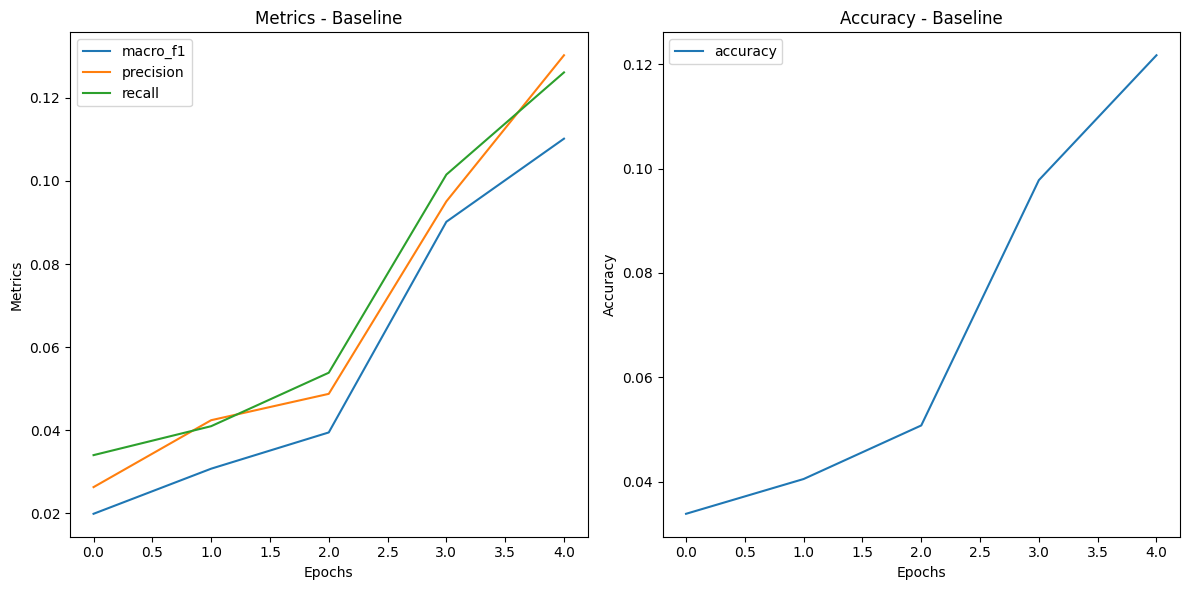

In [45]:
import matplotlib.pyplot as plt

def metrics_plots(metrics_dict, model_name):
    keys = list(metrics_dict.keys())
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title('Metrics - ' + model_name)
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    for metric in keys:
        if metric != 'accuracy':
            mean_metric = np.mean(list(metrics_dict[metric].values()), axis=0)
            plt.plot(mean_metric, label=metric)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Accuracy - ' + model_name)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    mean_accuracy = np.mean(list(metrics_dict['accuracy'].values()), axis=0)
    plt.plot(mean_accuracy, label='accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

metrics_plots(metrics_dict, model.name)

Most frequent tags:  [('NN', 4513), ('IN', 3275), ('DT', 2754), ('NNP', 2704), ('NNS', 2102), ('JJ', 1924), ('CD', 1249), ('VB', 956)]
Less frequent tags:  [('FW', 2), ('UH', 2), ('LS', 3), ('WP$', 4), ('RBS', 13), ('PDT', 14), ('EX', 34), ('RBR', 35)]


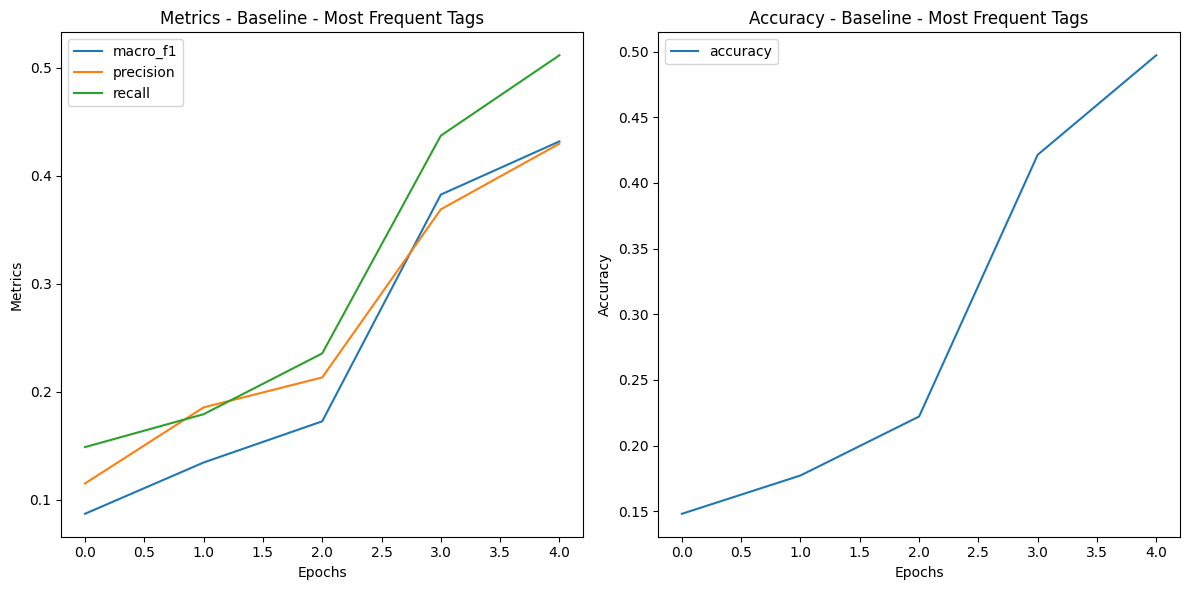

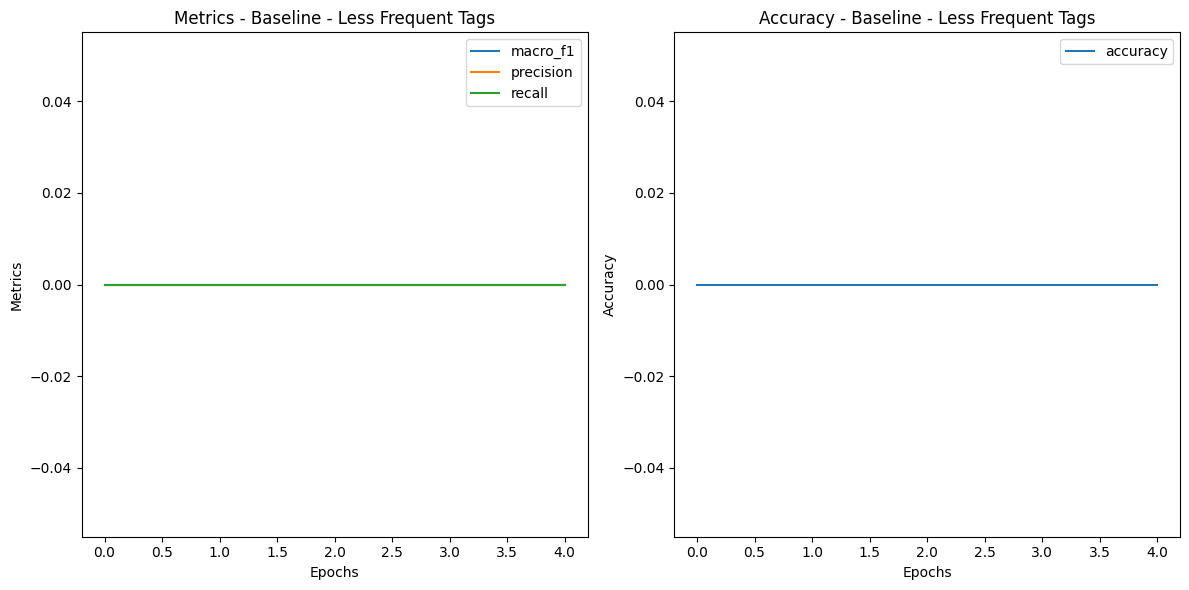

In [46]:
y_val_pos = [ [pos for pos in df_val[df_val['phrase_id']==nr_phrase]['pos']] for nr_phrase in set(df_val['phrase_id']) ]
y_val_pos_flat = [tag for phrase in y_val_pos for tag in phrase]
y_val_pos_clean = [tag for tag in y_val_pos_flat if tag not in ignore_classes]
mf_tags = sorted(set(y_val_pos_clean), key=y_val_pos_clean.count, reverse=True)[:8]
lf_tags = sorted(set(y_val_pos_clean), key=y_val_pos_clean.count)[:8]

mf_metrics_dict = {'macro_f1': {tag: metrics_dict['macro_f1'][tag] for tag in mf_tags},
                   'precision': {tag: metrics_dict['precision'][tag] for tag in mf_tags},
                   'recall': {tag: metrics_dict['recall'][tag] for tag in mf_tags},
                   'accuracy': {tag: metrics_dict['accuracy'][tag] for tag in mf_tags}}

lf_metrics_dict = {'macro_f1': {tag: metrics_dict['macro_f1'][tag] for tag in lf_tags},
                   'precision': {tag: metrics_dict['precision'][tag] for tag in lf_tags},
                   'recall': {tag: metrics_dict['recall'][tag] for tag in lf_tags},
                   'accuracy': {tag: metrics_dict['accuracy'][tag] for tag in lf_tags}}

print("Most frequent tags: ", [(tag, y_val_pos_clean.count(tag)) for tag in mf_tags])
print("Less frequent tags: ", [(tag, y_val_pos_clean.count(tag)) for tag in lf_tags])

metrics_plots(mf_metrics_dict, model.name + " - Most Frequent Tags")
metrics_plots(lf_metrics_dict, model.name + " - Less Frequent Tags")

AttributeError: 'dict' object has no attribute 'history'

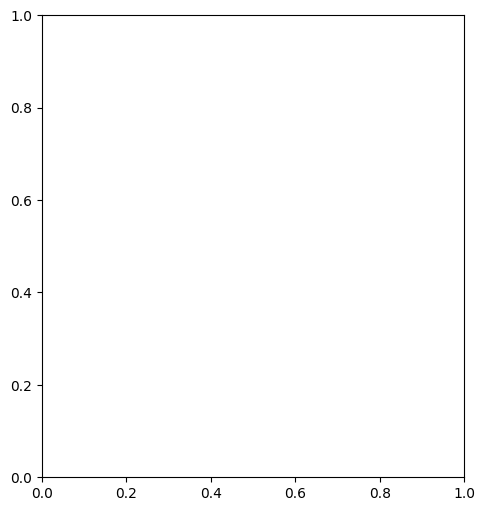

In [47]:
def graph_plots(history, model_name):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(['accuracy', 'val_accuracy'])
    plt.title('Accuracy - ' + model_name)
    
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(['loss', 'val_loss'])
    plt.title('Loss - ' + model_name)

    plt.tight_layout()
    plt.show()

graph_plots(history, model.name)

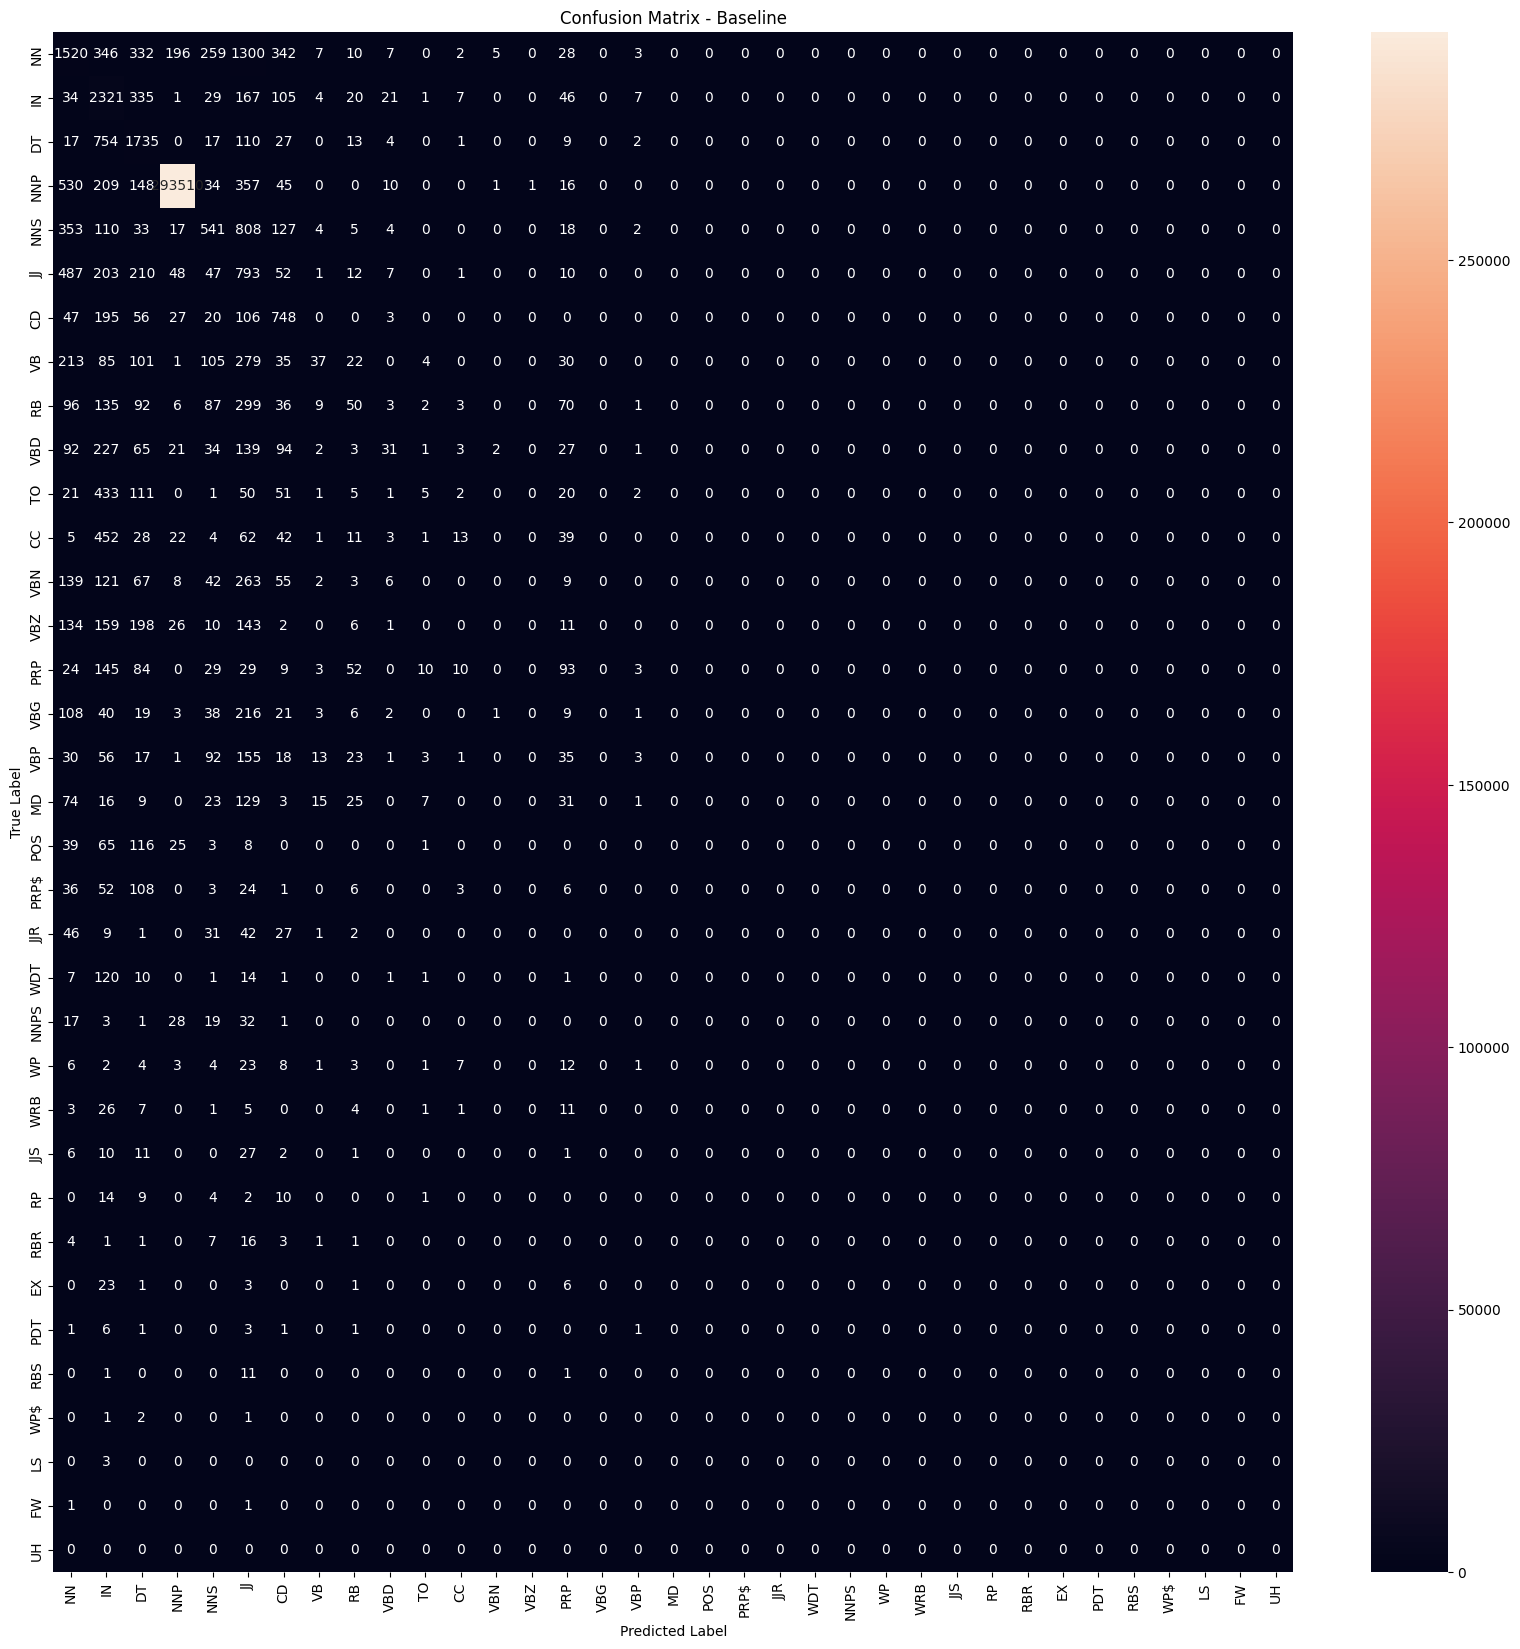

In [50]:
import seaborn as sns

pos_tags = [pos for pos in list_of_pos if pos not in ignore_classes]

pos_tags_sorted = sorted(set(y_val_pos_clean), key=y_val_pos_clean.count, reverse=True)
cm_sorted = cm[[pos_tags.index(tag) for tag in pos_tags_sorted]][:, [pos_tags.index(tag) for tag in pos_tags_sorted]]

plt.figure(figsize=(20, 20))
sns.heatmap(cm_sorted, annot=True, fmt='d', xticklabels=pos_tags_sorted, yticklabels=pos_tags_sorted)
plt.title('Confusion Matrix - ' + model.name)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# [Task 6 - 1.0 points] Error Analysis

You are tasked to evaluate your best performing model.

### Instructions

* Compare the errors made on the validation and test sets.
* Aggregate model errors into categories (if possible)
* Comment the about errors and propose possible solutions on how to address them.

# [Task 7 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

LaTex link https://it.overleaf.com/project/655cd1d053810bc1cd65fae8

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.

### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Error Analysis

Some topics for discussion include:
   * Model performance on most/less frequent classes.
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Punctuation

**Do not** remove punctuation from documents since it may be helpful to the model.

You should **ignore** it during metrics computation.

If you are curious, you can run additional experiments to verify the impact of removing punctuation.

# The End